# Zeiss website analysis

This notebook analyses Zeiss web pages for used key words. The (assumed) objective is to identify used key words on the website for latter comparison with competitors to optimize marketing and SEO.

### Process

1. Load data using seleinum web scraping: First, all product pages from the medical vertical are collected
2. For these webpages, the 'text text--body-m' parts of html documents are scrapped and stored in a .csv.
3. Load data from Csv: Data is stored in a single csv, holding the lyrics of all eminem songs.
4. Preprocessing: Includes casting to lower case, mapping of contractions, removing numbers, punctuation, stopwords and lemmatization
5. Count frequencies of phrases: First strings holding one/three words are built, then their frequency is counted
6. Visualize results: A bar chart visualizes the frequency of the word/text patterns

### Potential improvements

Exclude patterns that relate to the frame of the webpages


### Imports

In [1]:

import pandas as pd
import numpy as np
import urllib.request
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium import webdriver
from bs4 import BeautifulSoup
import Functions

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ga67xer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ga67xer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ga67xer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ga67xer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load data

In [2]:
# Set initial variables
WEBSITE = "https://www.zeiss.com/meditec/int/home.html?vaURL=www.zeiss.com/med"
CHROMEDRIVER = r"C:\Users\ga67xer\PycharmProjects\FileRetriever\chromedriver.exe"
chrome_options = Options()
#chrome_options.add_argument("--headless") # Ensure GUI is off
chrome_options.add_argument("--no-sandbox")
PATH = "G:\Zeiss\data\ZeissPages.csv"

In [13]:
### Initiate webdriver
driver = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)
driver.get(WEBSITE)
html = driver.page_source

[WDM] - Downloading: 100%|██████████| 6.13M/6.13M [00:00<00:00, 11.5MB/s]
c:\Users\ga67xer\Anaconda3\envs\Tensorflow2\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning:

executable_path has been deprecated, please pass in a Service object



In [14]:
#Scrap website to find product links
soup = BeautifulSoup(html, "html.parser")
links = []
for link in soup.findAll('a'):
    text = link.get('href')
    if text is not None:
        if "product" in text and text.startswith("http"):
            links.append(link.get('href'))


In [15]:
len(links)

19

In [147]:
#Scrap product websites for text class elements and export it to a csv
for link in links:
    driver.get(link)
    content = driver.find_elements(By.CLASS_NAME, "text")
    rawtext = []
    for text in content:
        rawtext.append(text.text)
    df = pd.DataFrame(rawtext, columns = ["Text"])
    df.to_csv(PATH, mode='a', header=False)


In [12]:
#Load csv
df = pd.read_csv(PATH, header=None, index_col=0)
df = df.dropna()

485

### Preprocessing

In [4]:
# Cast text to lower case, remove contractions, numbers, punctuations, whitespaces, stopwords and lemmatize
df['text_clean1'] = df[1].apply(Functions.to_lower)
df['text_clean2'] = df['text_clean1'].apply(Functions.main_contraction)
df['text_clean3'] = df['text_clean2'].apply(Functions.remove_numbers)
df['text_clean4'] = df['text_clean3'].apply(Functions.remove_punct)
df['text_clean5'] = df['text_clean4'].apply(Functions.to_strip)
df['text_clean6'] = df['text_clean5'].apply(Functions.remove_stopwords)
df['text_lemma'] = df['text_clean6'].apply(Functions.lemmatize)

### Phrase frequency

In [5]:
# Create one row per word
single_words = df['text_lemma'].str.extractall('([a-zA_Z]+)')
single_words.columns = ['Word']
single_words = single_words.reset_index(drop=True)

In [16]:
len(single_words)

4800

In [6]:
# Create one row with three words
joined_rows = []
length_patterns = 3
for i in range(len(single_words.values)-(length_patterns)):
    joined_text = single_words.values[i][0]
    for j in range(1, length_patterns):
        joined_text += " "
        joined_text += single_words.values[i+j][0]
    joined_rows.append(joined_text)
pattern_df = pd.DataFrame(joined_rows, columns = ["Patterns"])

### Results

Text(0, 0.5, 'Frequency of pattern')

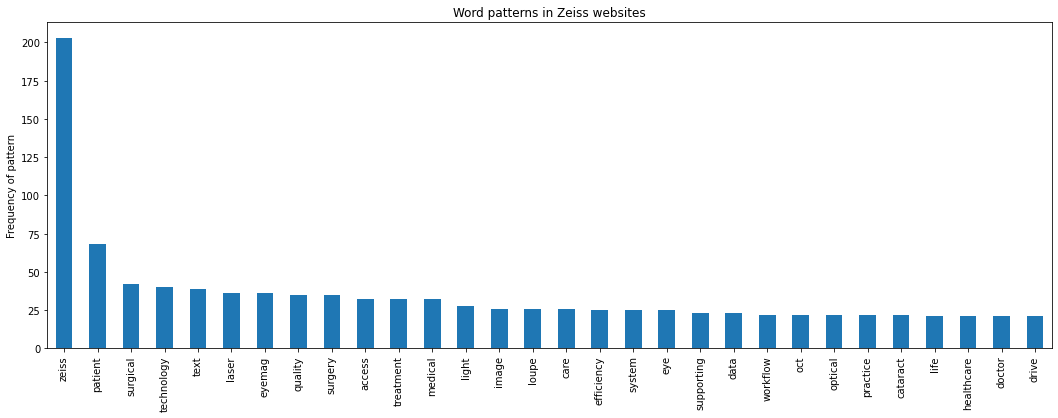

In [7]:
# Count frequency of single words and visualize
word_counts = single_words.value_counts()[:30]
word_counts.index = [str(e[0]) for e in word_counts.index.values]
ax =word_counts.plot.bar(figsize=(18,6), title = "Word patterns in Zeiss websites")
ax.set_ylabel("Frequency of pattern")

Text(0, 0.5, 'Frequency of pattern')

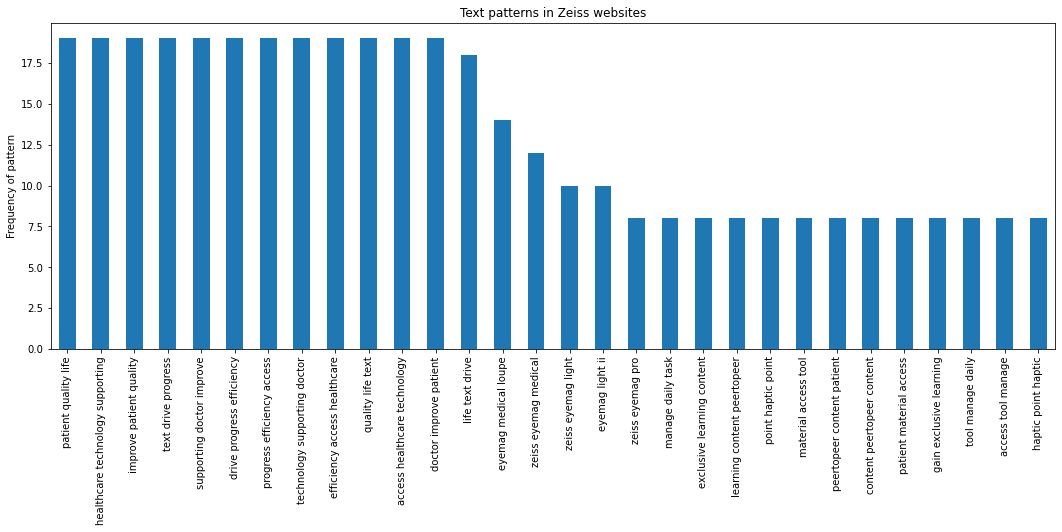

In [9]:
# Count frequency of word patterns and visualize
counts = pattern_df.value_counts()
counts.index = [str(e[0]) for e in pattern_df.value_counts().index.values]
ax = counts[:30].plot.bar( figsize=(18,6), title='Text patterns in Zeiss websites')
ax.set_ylabel("Frequency of pattern")

### Export for presentation

In [10]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"
counts = counts.sort_values()
fig = go.Figure(go.Bar(x = counts[-10:], y = counts.index[-10:], orientation='h'))
fig.update_layout(template = "simple_white", xaxis_title = "Frequency", yaxis_title = "Word pattern")
fig.show()
fig.write_image("G:\Zeiss\data\Zeiss word pattern.svg")

word_counts = word_counts.sort_values()
fig = go.Figure(go.Bar(x = word_counts[-10:], y = word_counts.index[-10:], orientation='h'))
fig.update_layout(template = "simple_white", xaxis_title = "Frequency", yaxis_title = "Words")
fig.show()
fig.write_image("G:\Zeiss\data\Zeiss words.svg")